In [13]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path
from PIL import Image

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

In [15]:
# Lectura de dataset

data_dir = ('CIFAR-10-only train')
data_dir = pathlib.Path(data_dir)

# Lectura de la carpeta train
data_dir_train = ('CIFAR-10-only train/train-corrupted-brightness')
data_dir_train = pathlib.Path(data_dir_train)



image_count_train = len(list(data_dir_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train


print(f"Cantidad de imagenes de train: {image_count_train}")


Cantidad de imagenes de train: 100000


In [16]:
# Convertir el dataset Corrupto

"""
directorio_corrupto_npy = ('CIFAR-10-C')  # Directorio en donde estan los archivos .npy
data_dir_corrupto_png = ('CIFAR-10-C-brightness')  # Directorio en donde se guardaran las imagenes en .png

archivos = [f for f in os.listdir(directorio_corrupto_npy) if f.endswith('.npy')]   # Lista de todos los archivos .npy en el directorio

for archivo in archivos:
    # Cargar el archivo .npy
    data = np.load(os.path.join(directorio_corrupto_npy, archivo))   

    # Convertir los datos a una imagen
    image = Image.fromarray(data.astype(np.uint8))

    # Crear un nombre para la imagen basado en el nombre del archivo .npy
    nombre_imagen = os.path.splitext(archivo)[0] + '.png'  

    # Guardar la imagen en el directorio de salida
    image.save(os.path.join(data_dir_corrupto_png, nombre_imagen))

"""


"\ndirectorio_corrupto_npy = ('CIFAR-10-C')  # Directorio en donde estan los archivos .npy\ndata_dir_corrupto_png = ('CIFAR-10-C-brightness')  # Directorio en donde se guardaran las imagenes en .png\n\narchivos = [f for f in os.listdir(directorio_corrupto_npy) if f.endswith('.npy')]   # Lista de todos los archivos .npy en el directorio\n\nfor archivo in archivos:\n    # Cargar el archivo .npy\n    data = np.load(os.path.join(directorio_corrupto_npy, archivo))   \n\n    # Convertir los datos a una imagen\n    image = Image.fromarray(data.astype(np.uint8))\n\n    # Crear un nombre para la imagen basado en el nombre del archivo .npy\n    nombre_imagen = os.path.splitext(archivo)[0] + '.png'  \n\n    # Guardar la imagen en el directorio de salida\n    image.save(os.path.join(data_dir_corrupto_png, nombre_imagen))\n\n"

In [17]:

"""
# Ruta donde se creará la carpeta
data_dir_corrupto_png = ('...')  # Directorio en donde se guardaran las imagenes en .png

# Ruta de etiquetas
dir_labels = ('CIFAR-10-C/labels.npy')

# Crea la carpeta
try:
  os.mkdir(data_dir_corrupto_png)
except FileExistsError:
  print(f"La carpeta '{data_dir_corrupto_png}' ya existe.")
else:
  print(f"La carpeta '{data_dir_corrupto_png}' se ha creado correctamente.")

# Función para exportar todas las imágenes de test corruptas a un directorio (en Png)
def exportar_imagenes_test(ruta_imagenes, ruta_etiquetas, ruta_corrupt):
  # Cargar las imágenes y etiquetas
  imagenes = np.load(ruta_imagenes)
  etiquetas = np.load(ruta_etiquetas)

  # Crear carpetas para cada clase
  for clase in np.unique(etiquetas):
      os.makedirs(f"{ruta_corrupt}{clase}", exist_ok=True)

  # Exportar las imágenes como PNG
  for i, imagen in enumerate(imagenes):
      imagen_png = Image.fromarray(imagen.reshape((32, 32, 3)), mode="RGB")
      imagen_png.save(f"{ruta_corrupt}{etiquetas[i]}/{i:05d}.png")

# Directorio en donde están los archivos .npy
directorio_corrupto_npy = ('CIFAR-10-C')  # Directorio en donde estan los archivos .npy

# Lista las subcarpetas
files = os.listdir(directorio_corrupto_npy)

# Recorre cada subcarpeta
for file in files:
  if file != ".ipynb_checkpoints":
    ruta_imagenes = directorio_corrupto_npy + "/" + file
    ruta_etiquetas = dir_labels
    ruta_corrupt = data_dir_corrupto_png + file + "/"
    exportar_imagenes_test(ruta_imagenes, ruta_etiquetas, ruta_corrupt)

"""


'\n# Ruta donde se creará la carpeta\ndata_dir_corrupto_png = (\'...\')  # Directorio en donde se guardaran las imagenes en .png\n\n# Ruta de etiquetas\ndir_labels = (\'CIFAR-10-C/labels.npy\')\n\n# Crea la carpeta\ntry:\n  os.mkdir(data_dir_corrupto_png)\nexcept FileExistsError:\n  print(f"La carpeta \'{data_dir_corrupto_png}\' ya existe.")\nelse:\n  print(f"La carpeta \'{data_dir_corrupto_png}\' se ha creado correctamente.")\n\n# Función para exportar todas las imágenes de test corruptas a un directorio (en Png)\ndef exportar_imagenes_test(ruta_imagenes, ruta_etiquetas, ruta_corrupt):\n  # Cargar las imágenes y etiquetas\n  imagenes = np.load(ruta_imagenes)\n  etiquetas = np.load(ruta_etiquetas)\n\n  # Crear carpetas para cada clase\n  for clase in np.unique(etiquetas):\n      os.makedirs(f"{ruta_corrupt}{clase}", exist_ok=True)\n\n  # Exportar las imágenes como PNG\n  for i, imagen in enumerate(imagenes):\n      imagen_png = Image.fromarray(imagen.reshape((32, 32, 3)), mode="RGB")\n

In [18]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = image_count_train

In [19]:

import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100000 files belonging to 20 classes.


In [20]:
class_names = train_ds.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 20
Los nombres de las clases son: ['airplane', 'airplane_c_b', 'automobile', 'automobile_c_b', 'bird', 'bird_c_b', 'cat', 'cat_c_b', 'deer', 'deer_c_b', 'dog', 'dog_c_b', 'frog', 'frog_c_b', 'horse', 'horse_c_b', 'ship', 'ship_c_b', 'truck', 'truck_c_b']


In [21]:
for images, labels0 in train_ds.take(1):  # only take first element of dataset
    x_train = images.numpy()
    y_train = labels0.numpy()

x_train /= 255.0  # Scale the features to the [0, 1] range
#x_train = x_train.reshape(len(x_train), 1, 256, 256)  # reshape into [N, C, H, W] for PyTorch
print(x_train.shape)

(100000, 32, 32, 3)


c:\Users\Cesar\Desktop\Proyecto-de-grado-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\Desktop\Proyecto-de-grado-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


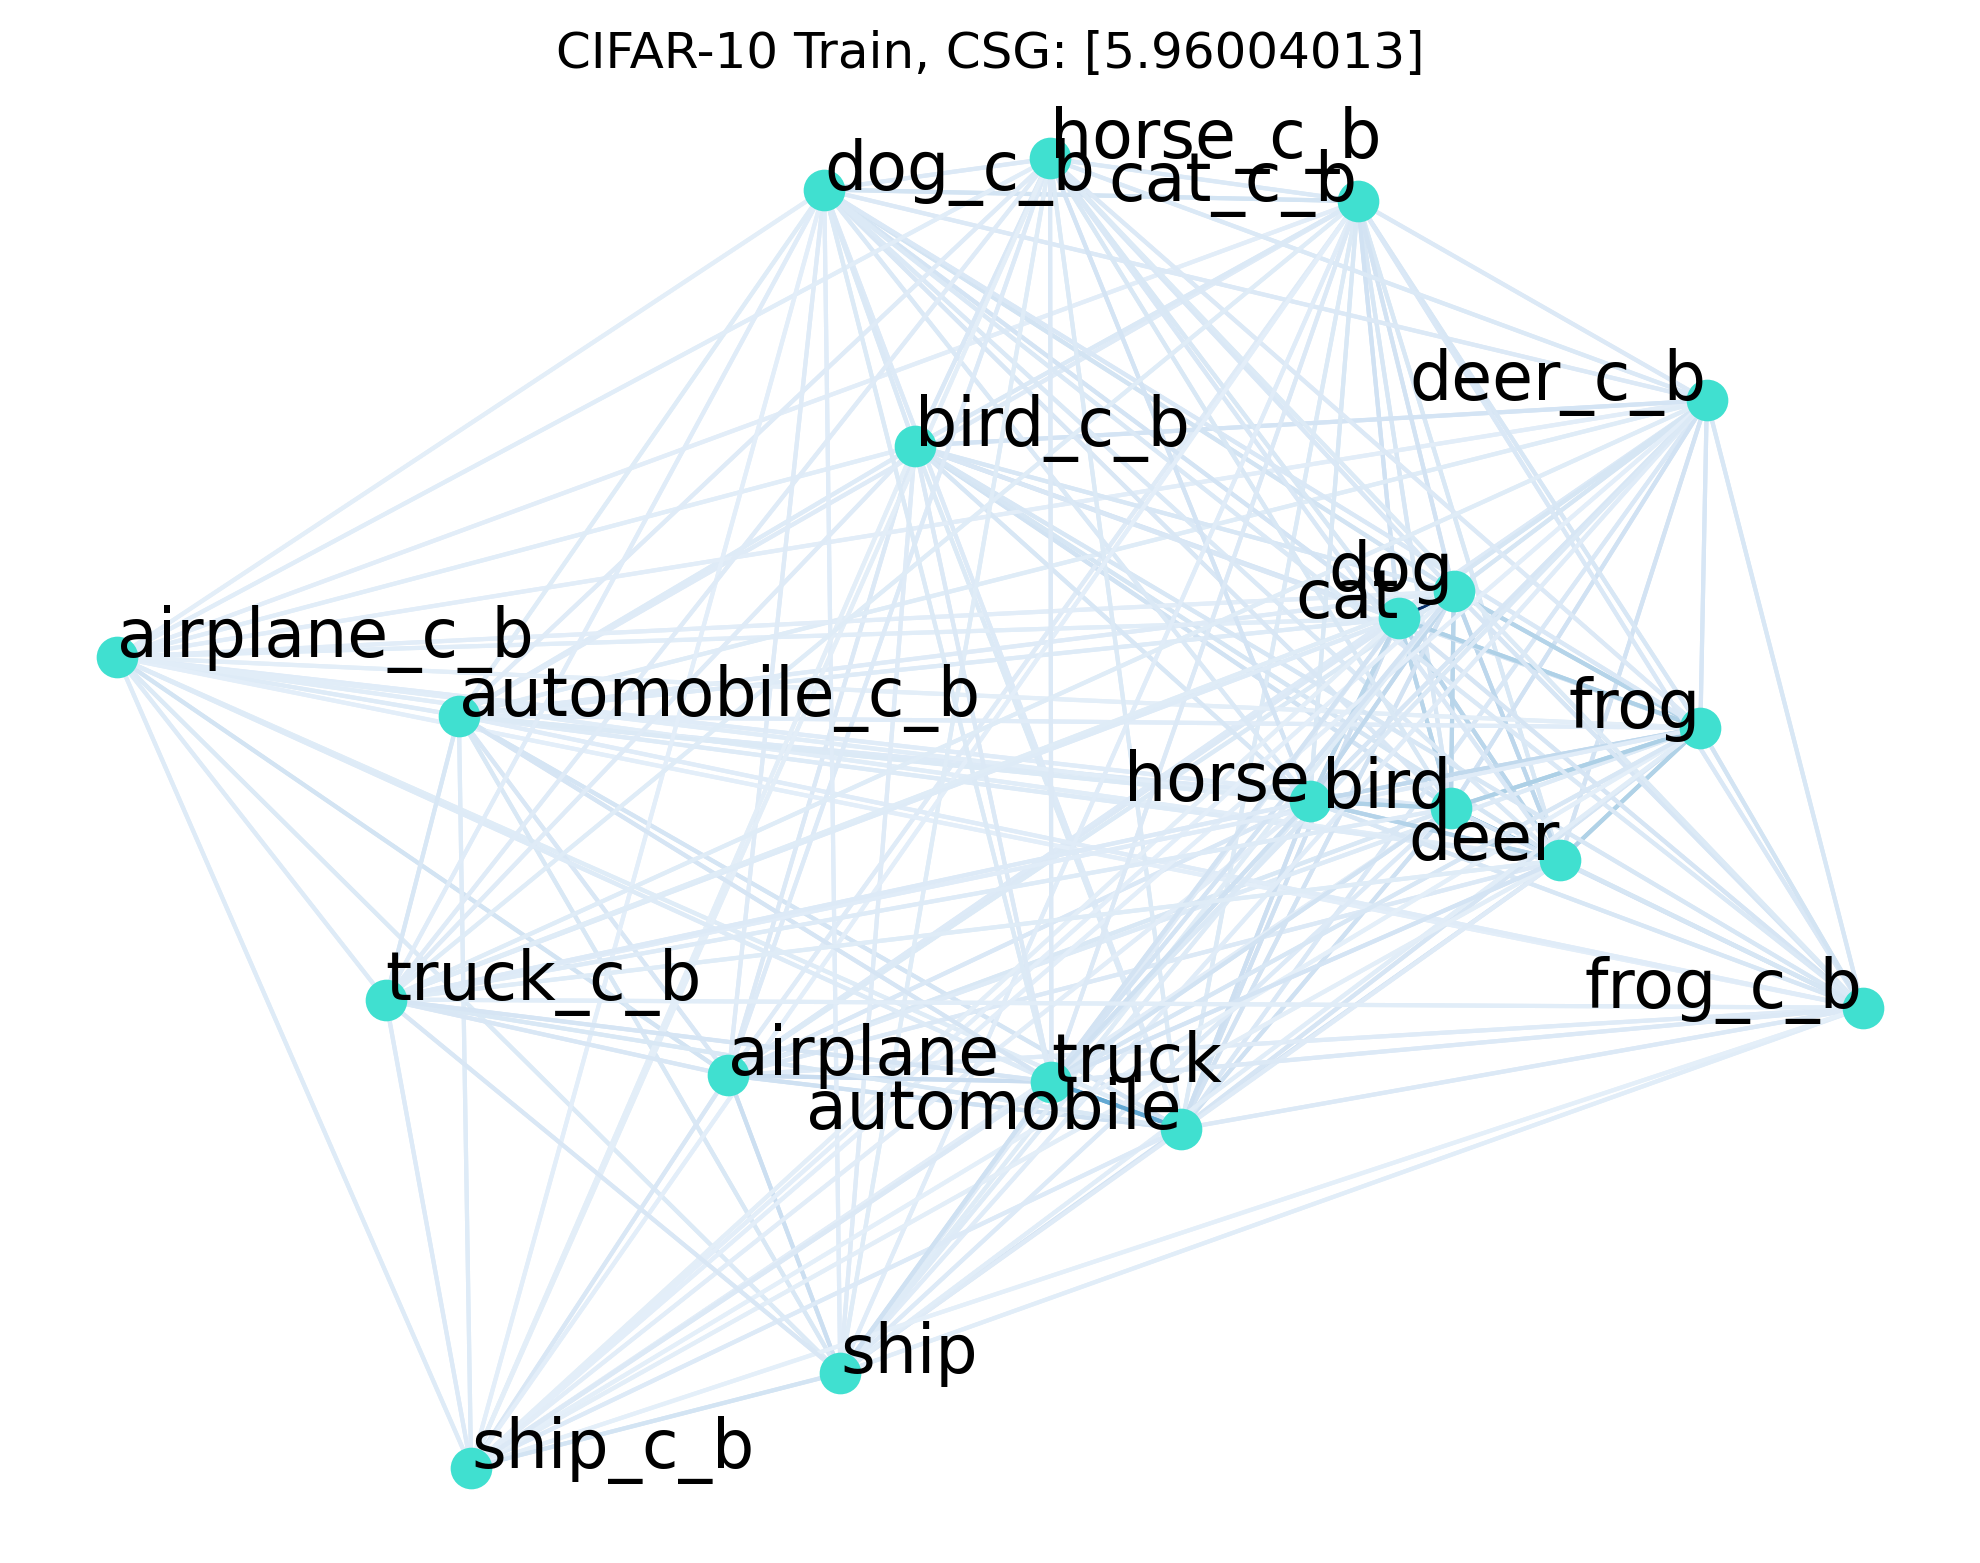

In [22]:
# CIFAR-10 TRAIN SET
X = x_train.reshape( (x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]))
y = y_train.reshape(y_train.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)
estimator.fit(data=X, target=y)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

# Plot the dataset
#make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

#make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=["airplane", "automobile", "bird",  "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

#make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=["airplane", "airplane_t", "automobile", "automobile_t", "bird", "bird_t",  "cat", "cat_t", "deer", "deer_t", "dog", "dog_t", "frog", "frog_t", "horse", "horse_t", "ship", "ship_t", "truck", "truck_t"])

make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=class_names)
           

In [23]:
# Let's compute the W matrix from Branchaud et al. and try to find overlapping classes.
from spectral_metric.estimator import CumulativeGradientEstimator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from spectral_metric.visualize import make_graph

#X, y = features, np.array(ds['intent'])  # Your dataset with shape [N, ?], [N]

#estimator = CumulativeGradientEstimator(M_sample=250, k_nearest=5, distance="cosine")
#estimator.fit(data=X, target=y)

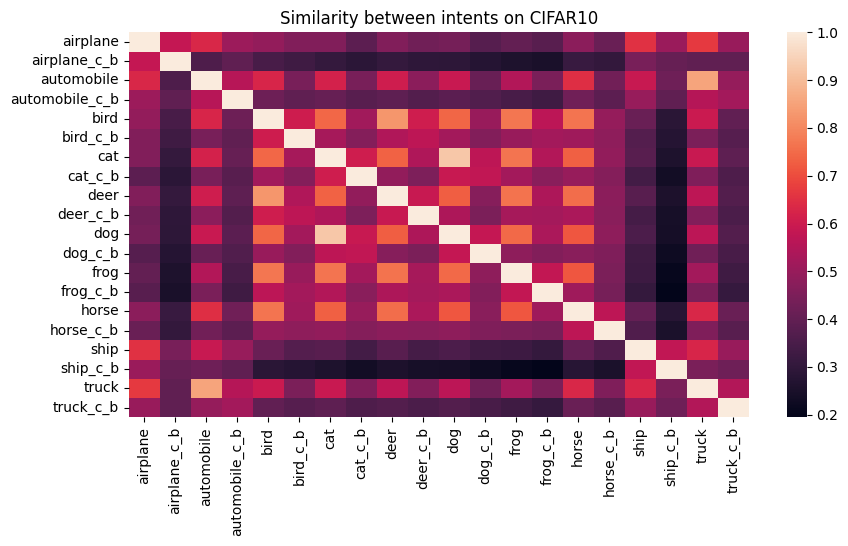

In [24]:
plt.figure(figsize=(10,5))
# Establecer las etiquetas del eje y con los nombres de las clases
sns.heatmap(estimator.W, xticklabels=class_names, yticklabels=class_names)
plt.title("Similarity between intents on CIFAR10")
plt.show()

In [25]:
#class_names=["airplane", "automobile", "bird",  "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#class_names=["airplane", "airplane_t", "automobile", "automobile_t", "bird", "bird_t",  "cat", "cat_t", "deer", "deer_t", "dog", "dog_t", "frog", "frog_t", "horse", "horse_t", "ship", "ship_t", "truck", "truck_t"]

from scipy.stats import entropy
import pandas as pd
entropy_per_class = entropy(estimator.W / estimator.W.sum(-1)[:, None], axis=-1)
print("Class that is the most confused (highest entropy):", class_names[np.argmax(entropy_per_class)])

Class that is the most confused (highest entropy): truck


In [26]:
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))[::-1]
pairs = [(i,j) for i,j in pairs if i != j]

In [27]:
print("Most similar pairs")
lst = []
for idx, (i,j) in enumerate(pairs[::2][:10]):
    lst.append({"Intent pair" : f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i,j]})
print(pd.DataFrame(lst))

Most similar pairs
           Intent pair  Similarity
0           cat <> dog      0.9238
1  truck <> automobile      0.8539
2         deer <> bird      0.8244
3         frog <> bird      0.7699
4        horse <> bird      0.7671
5          cat <> frog      0.7647
6         frog <> deer      0.7620
7        horse <> deer      0.7524
8          dog <> frog      0.7482
9          cat <> bird      0.7430


In [28]:
def show_most_confused(source_intent, target_intent, estimator, class_names):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    closest_to_second = np.argsort([sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()])[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    for di in dataset_indices:
        # Obtén el índice de la clase
        class_index = int(y_train[int(di)])
        # Imprime el nombre de la clase usando 'class_names'
        print("\t", class_names[class_index])
        image = x_train[int(di)]
        plt.figure(figsize = (1,1))
        plt.imshow(image, cmap=plt.get_cmap('gray'))
        plt.show()


cat <> dog
	 cat


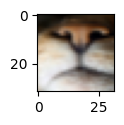

	 cat


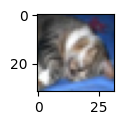

	 cat


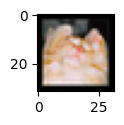

	 cat


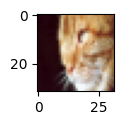

	 cat


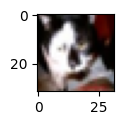

	 cat


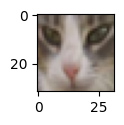

	 cat


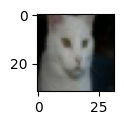

	 cat


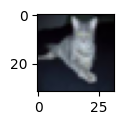

	 cat


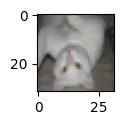

	 cat


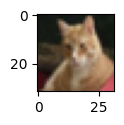

dog <> cat
	 dog


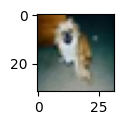

	 dog


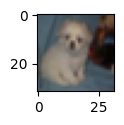

	 dog


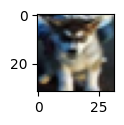

	 dog


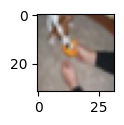

	 dog


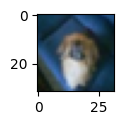

	 dog


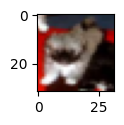

	 dog


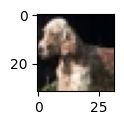

	 dog


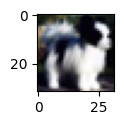

	 dog


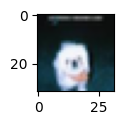

	 dog


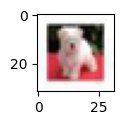

-----------------------------
truck <> automobile
	 truck


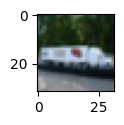

	 truck


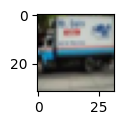

	 truck


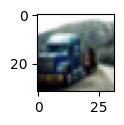

	 truck


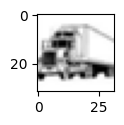

	 truck


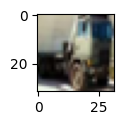

	 truck


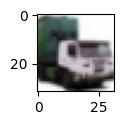

	 truck


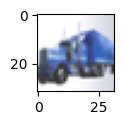

	 truck


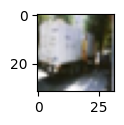

	 truck


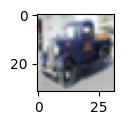

	 truck


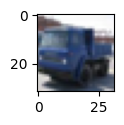

automobile <> truck
	 automobile


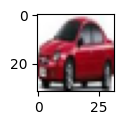

	 automobile


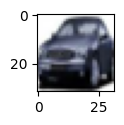

	 automobile


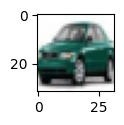

	 automobile


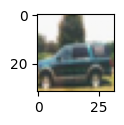

	 automobile


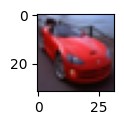

	 automobile


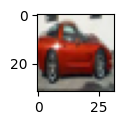

	 automobile


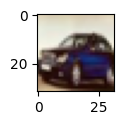

	 automobile


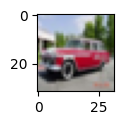

	 automobile


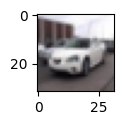

	 automobile


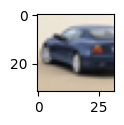

In [29]:
def show_most_confused(source_intent, target_intent, estimator, class_names):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    closest_to_second = np.argsort([sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()])[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    for di in dataset_indices:
        #print("\t", y_train[int(di)]["text"])
        class_index = int(y_train[int(di)])
        print("\t", class_names[class_index])
        image = x_train[int(di)]
        plt.figure(figsize = (1,1))
        plt.imshow(image, cmap=plt.get_cmap('gray'))
        plt.show()

first_pair = pairs[0]
show_most_confused(first_pair[0], first_pair[1], estimator, class_names)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names)

print("-----------------------------")
second_pair = pairs[2]
show_most_confused(second_pair[0], second_pair[1], estimator, class_names)
show_most_confused(second_pair[1], second_pair[0], estimator, class_names)


Idea: Identificar las imágenes con mayor probabilidad de pertenencia a otra clase, es decir a una clase distinta de la etiqueta (del vector de estimación)... para quitarlas del dataset y entrenar desde cero un modelo con este dataset recortado... para comparar su rendimiento con el del modelo entrenado con el dataset completo

In [30]:
def show_most_confused(source_intent, target_intent, estimator, class_names):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    closest_to_second = np.argsort([sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()])[::-1][:]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    for di in dataset_indices:
        #print("\t", y_train[int(di)]["text"])

        #print("\t", y_train[int(di)])
        print("\t", di)

        #image = x_train[int(di)]
        #plt.figure(figsize = (1,1))
        #plt.imshow(image, cmap=plt.get_cmap('gray'))
        #plt.show()

first_pair = pairs[0]
show_most_confused(first_pair[0], first_pair[1], estimator, class_names)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names)

print("-----------------------------")
second_pair = pairs[2]
show_most_confused(second_pair[0], second_pair[1], estimator, class_names)
show_most_confused(second_pair[1], second_pair[0], estimator, class_names)


A = estimator.similarity_arrays[first_pair[0]].values()

cat <> dog
	 33528
	 33947
	 31951
	 34667
	 31413
	 31519
	 30125
	 31067
	 30512
	 33163
	 33914
	 30190
	 34351
	 30123
	 31452
	 34719
	 31206
	 31188
	 34361
	 34945
	 32793
	 30953
	 31133
	 33784
	 31563
	 33191
	 30794
	 32431
	 33016
	 31556
	 31846
	 31531
	 30124
	 31944
	 30648
	 30341
	 31103
	 30342
	 31175
	 34502
	 32007
	 30696
	 34710
	 31790
	 34905
	 34872
	 33361
	 31832
	 33672
	 30773
	 34705
	 33559
	 33688
	 33402
	 30413
	 31760
	 31516
	 32221
	 34292
	 31053
	 30417
	 31522
	 31757
	 31733
	 34022
	 30367
	 31192
	 33562
	 30295
	 32446
	 34771
	 30435
	 33676
	 31559
	 32263
	 33010
	 34039
	 31288
	 31172
	 33142
	 30664
	 31388
	 34176
	 31390
	 34938
	 31822
	 34259
	 31364
	 34720
	 34520
	 34117
	 34567
	 30309
	 32714
	 33337
	 33246
	 33268
	 30790
	 31367
	 33941
	 32786
	 33848
	 31957
	 32162
	 32468
	 33207
	 33779
	 32900
	 31338
	 34378
	 32709
	 32236
	 30263
	 31037
	 30198
	 30797
	 34031
	 31717
	 32735
	 31816
	 33818
	 32926
	 34889
	 326